# Cold Strontium Atom Number Dependence on Some Measured Parameters
## Hiro Miyake
## August 20, 2017
### Contents
1. [Introduction](#introduction)
2. [Sr Lab Temperature and Humidity](#labtemp)
2. [Atom Number in the Broadband Red MOT](#stirrmot)
3. [Atom Number in the Single-Frequency Red MOT](#sfrmot)
4. [Atom Number in the Optical-Dipole Trap](#odt)
5. [Conclusions](#conclusions)

<a id="introduction"></a>
## 1. Introduction
Studying atomic gases cooled to temperatures of $\mu$K and lower are a major frontier in physics research. A common characteristic in all cutting-edge cold atom experiments is that the experimental apparatus are fairly complex, with many lasers, optics, and vacuum systems which are all susceptible to environmental disturbances that can be difficult to control, at the very least simply because of the complexity of the set up. Therefore, understanding the sources of experimental instabilities can be valuable to be able to take corrective action to increase the stability of the experiment. In this Jupyter notebook I explore how the measured atom number depends on a few easy-to-measure variables.

In our current set up, we can consider three stages before we are able to create a Bose-Einstein condensate of $^{84}$Sr. The first is where we load a magneto-optical trap (MOT) on the red transition at 689 nm where we rapidly vary the red laser frequency, which we call the broadband red MOT. The second is where we fix the red laser to a single frequency which we call the single frequency red MOT. The third stage is where we load the atoms into an optical-dipole trap (ODT) from the single frequency red MOT. In all of these cases, we are monitoring a few different observables.

Our main observable is the atom number `absnum` determined by summing the counts obtained by a charge-coupled device (CCD) camera. We also measure the `amplitude` which is determined by fitting the atoms to a Gaussian. This is expected to be closely correlated with `absnum`, and the data shown below bear this out. The most useful variable we monitor, which in our case can consider to be the 'independent' variable (even though we are not intentionally controlling this), is the `ClearMax` variable, which is the maximum number of CCD counts of the blue MOT fluorescence, which is an image taken one step before we take the image of the red MOT or ODT. If we can determine a clear correlation between `absnum` and `ClearMax`, then we can work to make the `ClearMax` variable more stable, or possibly correct for the atom number in the measurement step taking into account the `ClearMax` count.

We also have temperature and humidity measurements from the laboratory, which we can look at to see if there are any correlations with the atom numbers. A qualitative look at the data suggests temperature and humidity are not significant factors in determining atom number on the time scale of minutes to hours.

But first, let's load in the necessary packages.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## http://www.statsmodels.org/stable/index.html
import statsmodels.api as sm
import statsmodels.formula.api as smf

## http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
## http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
from sklearn import linear_model

## Loading a csv file into pandas
## https://chrisalbon.com/python/pandas_dataframe_importing_csv.html

## Visualization with pandas
## https://pandas.pydata.org/pandas-docs/stable/visualization.html

## Visualization with Seaborn
## https://seaborn.pydata.org
## http://blog.insightdatalabs.com/advanced-functionality-in-seaborn/
## https://chrisalbon.com/python/pandas_with_seaborn.html
## https://elitedatascience.com/python-seaborn-tutorial
## http://seaborn.pydata.org/tutorial.html

<a id="labtemp"></a>
## 2. Sr Lab Temperature and Humidity
In our lab, we are monitoring the temperature and humidity at 1 minute intervals. We can see if this might be affecting our atom number.

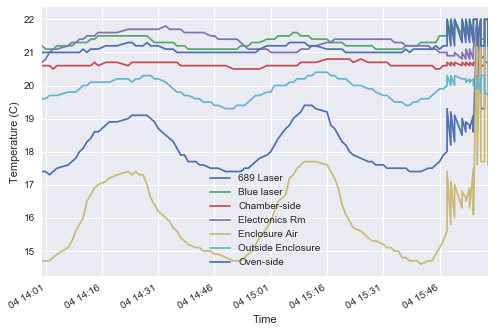

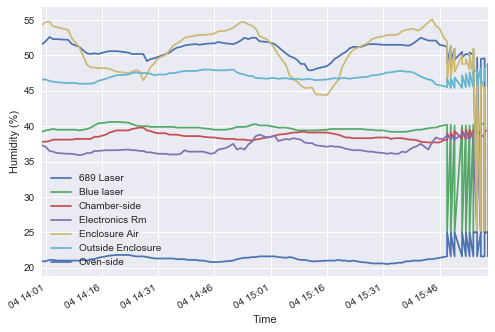

In [2]:
dftemp=pd.read_csv("data/temperature_grafana.csv", sep=';')
dfhum=pd.read_csv("data/humidity_grafana.csv", sep=';')

## Set the undefined entries to some value which won't mess up the plotting
## https://stackoverflow.com/questions/34794067/how-to-set-a-cell-to-nan-in-a-pandas-dataframe
dftemp.replace('undefined', 22, inplace = True)
dfhum.replace('undefined', 25, inplace = True)

dftemp['Time'] = pd.to_datetime(dftemp['Time'])
dfhum['Time'] = pd.to_datetime(dfhum['Time'])
## Manually convert to ET from UTC
dftemp['Time'] = dftemp['Time'] - pd.Timedelta('04:00:00')
dfhum['Time'] = dfhum['Time'] - pd.Timedelta('04:00:00')

## Convert str columns to float
for column in dftemp:
    if not (column == 'Time'):
        dftemp[column] = pd.to_numeric(dftemp[column])
        dfhum[column] = pd.to_numeric(dfhum[column])

#dftemp['689 Laser'] = 400000*dftemp['689 Laser']

#g = sns.pairplot(dftemp)
ax = dftemp.plot(x = 'Time')
ax.set_ylabel('Temperature (C)')
ax = dfhum.plot(x = 'Time')
ax.set_ylabel('Humidity (%)')

There is some periodicity of about 50 minutes. We see that proper readings were not taken after about `15:46`. We will look at these numbers in conjunction with atom numbers later.

<a id="stirrmot"></a>
## 3. Atom Number in the Broadband Red MOT
Here I will explore the atom number at the broadband red MOT step. Let's load our data into a pandas dataframe and normalize the `Timestamp` variable, called `timerel`, so that it is zero in the first row and all other subsequent rows are referenced to that. We also add a `datetime` column by converting the `Timestamp` and `timerel` information into an actual time and date by using the fact that the first data was taken at 2:25 PM on August 4, 2017.

In [3]:
df1=pd.read_csv("data/BBrMOT_Data.csv")
df1['timerel'] = df1['Timestamp'] - df1['Timestamp'][0]

basetime = '2017-08-04 14:25:00'
df1['datetime'] = basetime
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1['timerel'] = pd.to_timedelta(df1['timerel'], unit = 's')
df1['datetime'] = df1['datetime'] + df1['timerel']
#df1.head()

Let's make a plot of `absnum` and see how it depends on `Timestamp`.

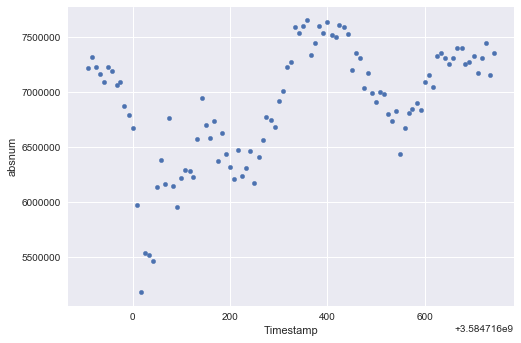

In [4]:
df1.plot.scatter(x='Timestamp', y='absnum')

We see that `absnum` is clearly varying as a function of time even though we are not intentionally changing anything.

Now instead of creating one plot at a time, let's use the [Seaborn](https://seaborn.pydata.org) package to plot all pair-wise plots at once.

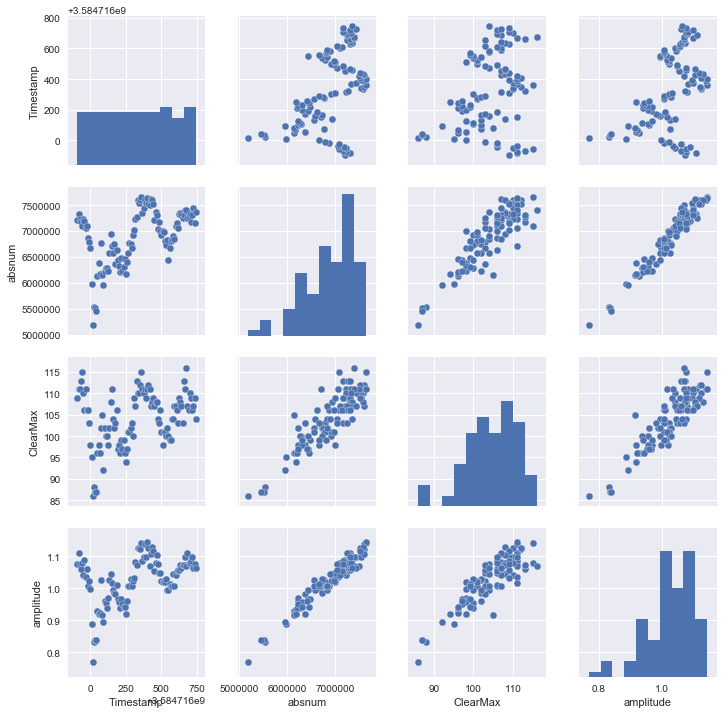

In [5]:
## http://blog.insightdatalabs.com/advanced-functionality-in-seaborn/
g = sns.pairplot(df1[["Timestamp", "absnum", "ClearMax", "amplitude"]])

As expected, there is a strong correlation between `absnum` and `amplitude`, since these are extracted from exactly the same plot and can be considered different ways of obtaining the same atom number.

A more interesting observation is that the `absnum` appears to be also strongly correlated with `ClearMax`, at least on this time scale. This means that on this time scale, if we are able to control `ClearMax` to a steady value, then `absnum` should also be stabilized.

Let's explore the relationship between `absnum` and `ClearMax` more carefully by performing a linear regression.

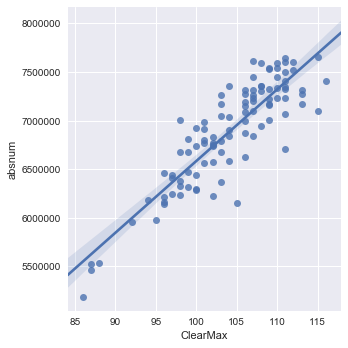

In [6]:
## https://elitedatascience.com/python-seaborn-tutorial
## https://seaborn.pydata.org/tutorial/regression.html
sns.lmplot(x='ClearMax', y='absnum', data=df1)

The fit looks quite good. Let's look at the residuals now.

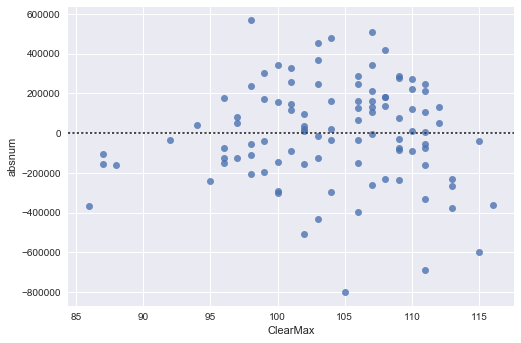

In [7]:
sns.residplot(x='ClearMax', y='absnum', data=df1)

The residuals look roughly Gaussian distributed around zero, so the liner fit is doing a decent job.

We can extract the fit parameters using the [statsmodels](http://www.statsmodels.org/stable/index.html) package.

In [8]:
lm1 = smf.ols('absnum ~ ClearMax', data=df1).fit()
print lm1.summary()

                            OLS Regression Results                            
Dep. Variable:                 absnum   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     336.0
Date:                Sun, 20 Aug 2017   Prob (F-statistic):           1.36e-33
Time:                        22:05:45   Log-Likelihood:                -1400.3
No. Observations:                 101   AIC:                             2805.
Df Residuals:                      99   BIC:                             2810.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -7.979e+05    4.2e+05     -1.900      0.0

Alternatively, we can also use the [scikit-learn](http://scikit-learn.org/stable/index.html) package to extract the fit parameters.

In [9]:
lm1_sk = linear_model.LinearRegression()

# Train the model using the training sets
ndata1 = len(df1.ClearMax.values)
lm1_sk.fit(df1.ClearMax.values.reshape((ndata1,1)), df1.absnum.values.reshape((ndata1,1)))
print 'The slope of the fit is: ' + str(lm1_sk.coef_)
print 'The intercept of the fit is: ' + str(lm1_sk.intercept_)
print 'The R squared is: ' +str(lm1_sk.score(df1.ClearMax.values.reshape((ndata1,1)), df1.absnum.values.reshape((ndata1,1))))

The slope of the fit is: [[ 73819.95631933]]
The intercept of the fit is: [-797909.06631401]
The R squared is: 0.772433024059


Note that using scikit-learn is more clumsy than using statsmodels and is more work to extract the parameters. Furthermore, detailed statistical information is more easily extracted using the statsmodels package. In general, scikit-learn is useful to make predictions from data, but statsmodels is better suited to understand the data.

Let's look at the broadband red MOT data in conjunction with the lab environment data.

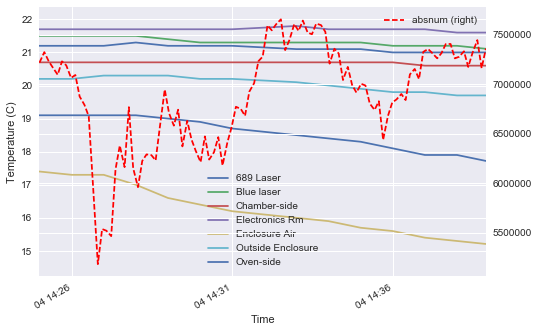

In [10]:
## https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure
## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
#ax = dftemp.plot(x = 'Time', y = '689 Laser')
#df1.plot(x = 'datetime', y = 'absnum', ax=ax)

## https://stackoverflow.com/questions/11640243/pandas-plot-multiple-y-axes
#df.A.plot(ax=ax, style='b-')
#df.B.plot(ax=ax2, style='r-', secondary_y=True)

fig, ax = plt.subplots()
ax2 = ax.twinx()
#fig.subplots_adjust(right=0.75)

dftemp.plot(x = 'Time', ax=ax)
#dftemp.plot(x = 'Time', y = '689 Laser', ax=ax, style='b-', label = '689 Laser')
df1.plot(x = 'datetime', y = 'absnum', ax=ax2, style='r--', secondary_y=True)
ax.set_ylabel('Temperature (C)')

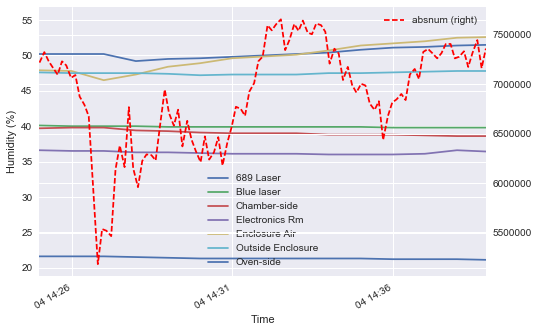

In [11]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

dfhum.plot(x = 'Time', ax=ax)
df1.plot(x = 'datetime', y = 'absnum', ax=ax2, style='r--', secondary_y=True)
ax.set_ylabel('Humidity (%)')

There doesn't appear to be any obvious strong correlation between `absnum` and the lab temperature or humidity.

<a id="sfrmot"></a>
## 4. Atom Number in the Single-Frequency Red MOT
Now let's take a look at the data taken after the next step, which is after loading to atoms into the single-frequency red MOT.

In [12]:
df2=pd.read_csv("data/SFrMOT_Data.csv")
df2['timerel'] = df2['Timestamp'] - df2['Timestamp'][0]

## I recorded that the data taking started 14:40
basetime = '2017-08-04 14:44:00'
df2['datetime'] = basetime
df2['datetime'] = pd.to_datetime(df2['datetime'])
df2['timerel'] = pd.to_timedelta(df2['timerel'], unit = 's')
df2['datetime'] = df2['datetime'] + df2['timerel']
#df2

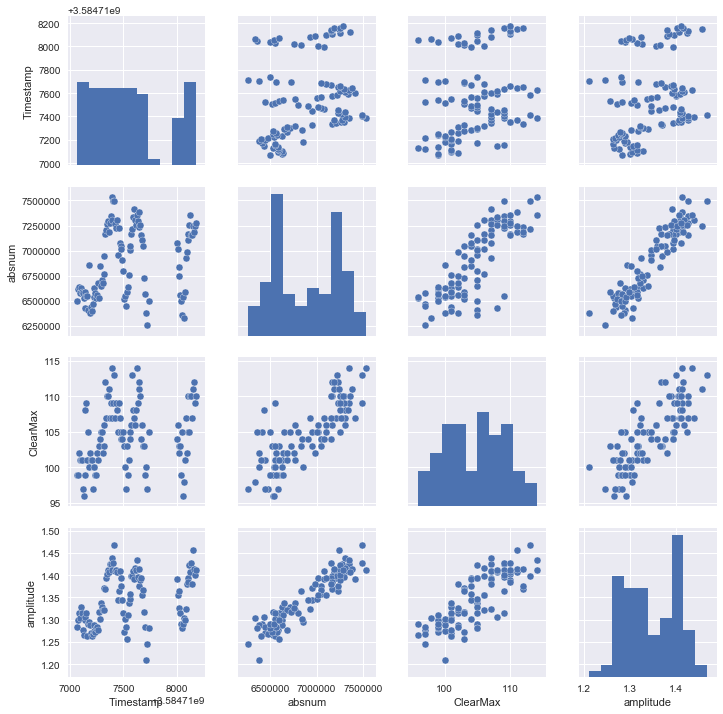

In [13]:
g = sns.pairplot(df2[["Timestamp", "absnum", "ClearMax", "amplitude"]])

The linear relationship between `absnum` and `ClearMax` appears to still hold. Let's look at this in more detail.

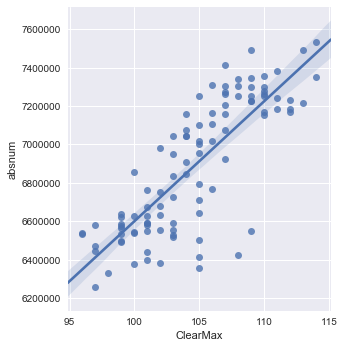

In [14]:
sns.lmplot(x='ClearMax', y='absnum', data=df2)

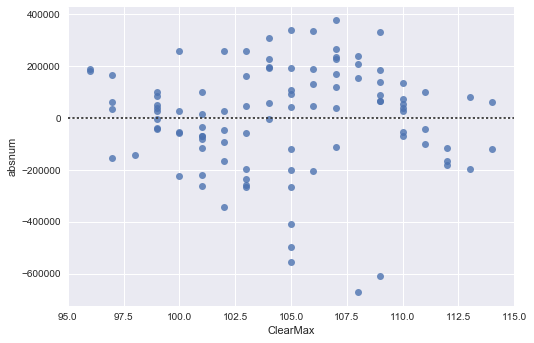

In [15]:
sns.residplot(x='ClearMax', y='absnum', data=df2)

In [16]:
lm2 = smf.ols('absnum ~ ClearMax', data=df2).fit()
print lm2.summary()

                            OLS Regression Results                            
Dep. Variable:                 absnum   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     185.8
Date:                Sun, 20 Aug 2017   Prob (F-statistic):           1.88e-24
Time:                        22:05:49   Log-Likelihood:                -1377.6
No. Observations:                 101   AIC:                             2759.
Df Residuals:                      99   BIC:                             2764.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.639e+05   4.79e+05      0.760      0.4

The linear fit looks decent and the residuals are roughly Gaussian.

Now let's look to see if temperature and humidity in the lab is correlated with atom number.

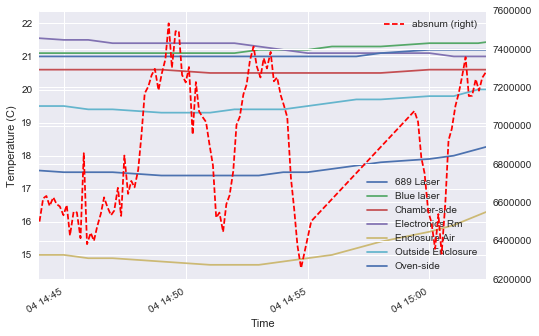

In [17]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

## Temperature data and absnum
dftemp.plot(x = 'Time', ax=ax)
df2.plot(x = 'datetime', y = 'absnum', ax=ax2, style='r--', secondary_y=True)
ax.set_ylabel('Temperature (C)')

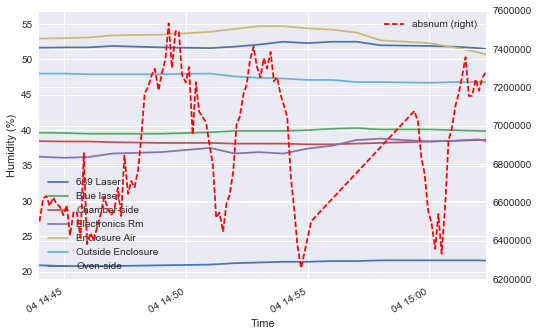

In [18]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

## Humidity data and absnum
dfhum.plot(x = 'Time', ax=ax)
df2.plot(x = 'datetime', y = 'absnum', ax=ax2, style='r--', secondary_y=True)
ax.set_ylabel('Humidity (%)')

Again, no obvious correlation between atom number and neither temperature nor humidity.

<a id="odt"></a>
## 5. Atom Number in the Optical-Dipole Trap
Now let's look at the atom number immediately after we load into the optical-dipole trap.

In [19]:
df3=pd.read_csv("data/LoadODT_Data.csv")
df3['timerel'] = df3['Timestamp'] - df3['Timestamp'][0]

## I recorded that the data taking started at 15:09
basetime = '2017-08-04 15:09:00'
df3['datetime'] = basetime
df3['datetime'] = pd.to_datetime(df3['datetime'])
df3['timerel'] = pd.to_timedelta(df3['timerel'], unit = 's')
df3['datetime'] = df3['datetime'] + df3['timerel']
#df3

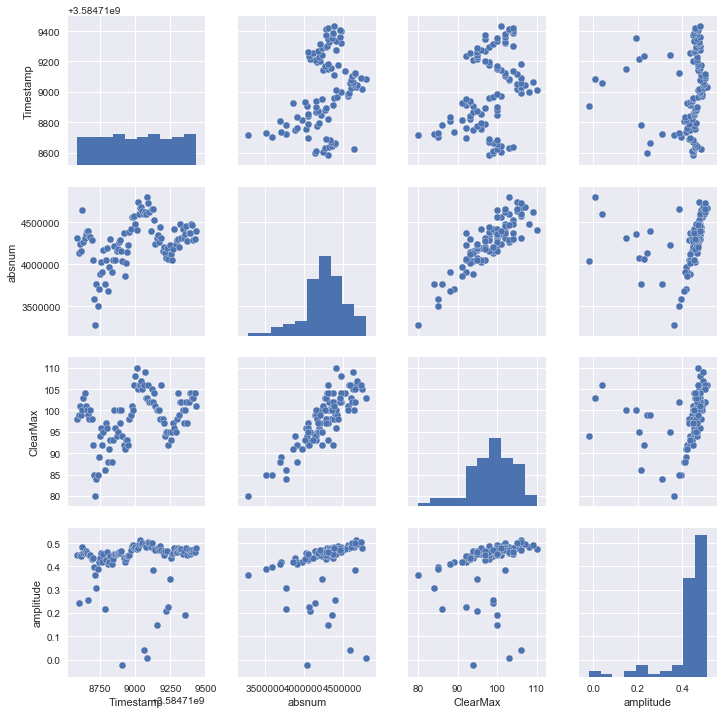

In [20]:
g = sns.pairplot(df3[["Timestamp", "absnum", "ClearMax", "amplitude"]])

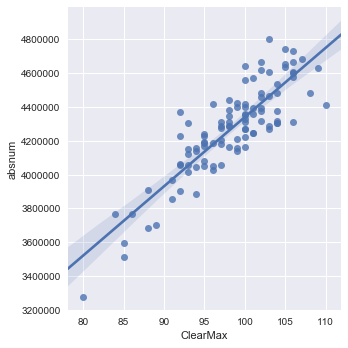

In [21]:
sns.lmplot(x='ClearMax', y='absnum', data=df3)

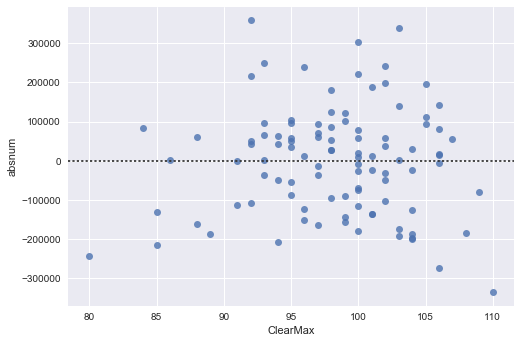

In [22]:
sns.residplot(x='ClearMax', y='absnum', data=df3)

In [23]:
lm3 = smf.ols('absnum ~ ClearMax', data=df3).fit()
print lm3.summary()

                            OLS Regression Results                            
Dep. Variable:                 absnum   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     292.7
Date:                Sun, 20 Aug 2017   Prob (F-statistic):           2.49e-31
Time:                        22:05:55   Log-Likelihood:                -1338.2
No. Observations:                 101   AIC:                             2680.
Df Residuals:                      99   BIC:                             2686.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.421e+05   2.36e+05      1.027      0.3

The linear relationship looks very strong and the residuals look Gaussian-distributed around zero.

Now let's look at atom number and it's relation to temperature and humidity.

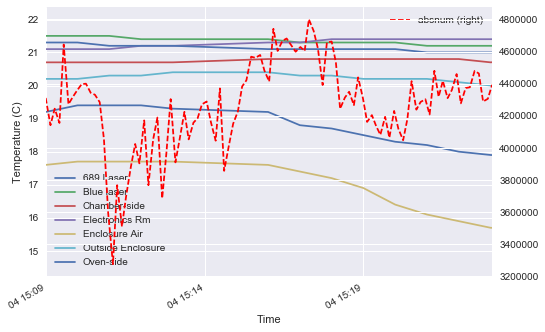

In [24]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

## Temperature data and absnum
dftemp.plot(x = 'Time', ax=ax)
df3.plot(x = 'datetime', y = 'absnum', ax=ax2, style='r--', secondary_y=True)
ax.set_ylabel('Temperature (C)')

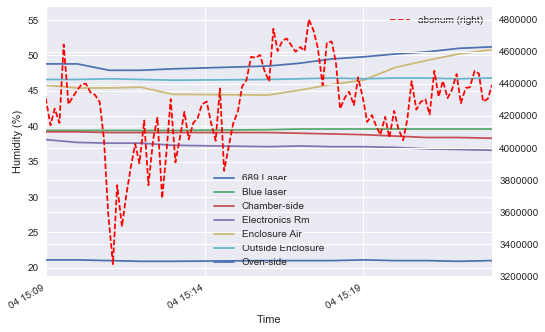

In [25]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

## Humidity data and absnum
dfhum.plot(x = 'Time', ax=ax)
df3.plot(x = 'datetime', y = 'absnum', ax=ax2, style='r--', secondary_y=True)
ax.set_ylabel('Humidity (%)')

Again, no obvious correlation between temperature and humidity with atom number.

<a id="conclusions"></a>
## 6. Conclusions
It appears that there is a strong linear relationship between `absnum` and `ClearMax` in the timescale of the data taking, starting with the stirred red MOT all the way to loading the ODT. This suggests that if we want to improve the stability of our atom number, we should stabilize the blue MOT fluorescence. This means we can ignore issues with the narrow line 689 nm laser and focus on improving factors before creating a red MOT.

However, from experience we know that if the atom number is coming down, there are experimental knobs having nothing to do with the blue MOT which can help to improve the atom number, such as the magnetic field during ODT loading and the red laser frequency detunings. Over longer timescales these factors may become dominant over blue MOT issues, but stabilizing the blue MOT fluorescence would certainly be a good start in stabilizing the atom number in the end.

Another thing one can potentially do is to correct for the atom number obtained at the end of an experimental cycle by using the `absnum` obtained and using the linear relationship. This would allow us to keep more of the data points, even those with low blue MOT counts. However, this assumes that the linear relationship holds all the time, and the correction may be non-trivial if you are looking for some controlled variation in the atom number of some physical process you are exploring, such as photoassociation losses. Furthermore this correction would not make sense if you are looking for some spatial effects on the atomic cloud, as this correction would apply only to the total atom count. Therefore, correcting for low atom number through the linear relationship between the atom number and blue MOT fluorescence is probably not a good idea.

The best way to stabilize the blue MOT fluorescence and atom number would be to load the blue MOT until the monitored fluorescence reaches a pre-specified value. This will ensure the blue MOT fluorescence is always at the same value before running the experiment. This involves feeding back measured counts on a CCD in real-time to the LabView SetList program.

Finally, although we have not performed a quantitative analysis of the correlation between lab temperature and humidity and atom number, plotting those as a function of time suggests that the lab environment does not directly affect atom number in any meaningful way. The effect of temperature and humidity is felt, if at all, mostly likely on a much longer timescale, of days or weeks.